# Computer Vision

In [95]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
from timeit import default_timer as timer
from tqdm.auto import tqdm
import pandas as pd

## get dataset

In [2]:
#using FashionMNIST
train_data = datasets.FashionMNIST(
    root="datasets",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="datasets",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [6]:
image, label = test_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [7]:
image.shape

torch.Size([1, 28, 28])

## visualize data

(-0.5, 27.5, 27.5, -0.5)

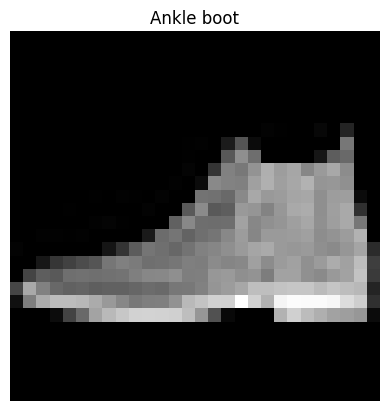

In [8]:
plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)

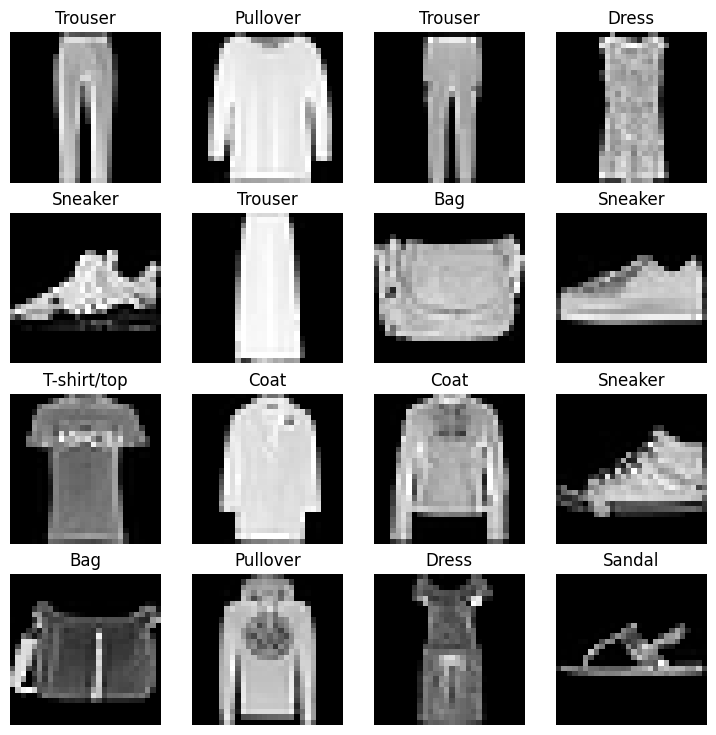

In [9]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## prepare dataloader

In [10]:
#setup batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [11]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f2a02295ca0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f2a02295d30>)

In [12]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

## create model

In [13]:
class FashionMNISTModelv0(nn.Module):

    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

model_8 = FashionMNISTModelv0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
)

In [14]:
dummy_x = torch.rand([1, 1, 28, 28])
model_8(dummy_x)

tensor([[ 0.0068,  0.3032,  0.3242,  0.0623,  0.3802, -0.1740, -0.0247, -0.2421,
          0.0533, -0.2154]], grad_fn=<AddmmBackward0>)

In [15]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_8.parameters(), lr=0.1)

In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [17]:
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"train time on {device} = {total_time:.3f} seconds")
    return total_time

## train and test

In [18]:
train_time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}\n-----")

    train_loss = 0
    train_acc = 0

    for batch, (x, y) in enumerate(train_dataloader):
        model_8.train()

        y_pred = model_8(x)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:

            print(f"batch no = {batch * len(x)}/{len(train_dataloader.dataset)}")
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    test_loss, test_acc = 0, 0

    model_8.eval()

    with torch.inference_mode():

        for x_test, y_test in test_dataloader:

            test_pred = model_8(x_test)

            test_loss += loss_fn(test_pred, y_test)

            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(test_dataloader)

        test_acc /= len(test_dataloader)

    print(f"train loss: {train_loss:.4f} | test loss: {test_loss:.4f} | train acc: {train_acc:.2f} | test acc: {test_acc:.2f}")

train_time_end = timer()

total_time = print_train_time(start=train_time_start, end=train_time_end)




  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
-----
batch no = 0/60000
batch no = 12800/60000
batch no = 25600/60000
batch no = 38400/60000
batch no = 51200/60000


 33%|███▎      | 1/3 [00:11<00:23, 11.54s/it]

train loss: 0.5886 | test loss: 0.4968 | train acc: 79.07 | test acc: 82.37
epoch: 1
-----
batch no = 0/60000
batch no = 12800/60000
batch no = 25600/60000
batch no = 38400/60000
batch no = 51200/60000


 67%|██████▋   | 2/3 [00:23<00:11, 11.65s/it]

train loss: 0.4756 | test loss: 0.5298 | train acc: 83.31 | test acc: 81.32
epoch: 2
-----
batch no = 0/60000
batch no = 12800/60000
batch no = 25600/60000
batch no = 38400/60000
batch no = 51200/60000


100%|██████████| 3/3 [00:35<00:00, 11.99s/it]

train loss: 0.4572 | test loss: 0.4899 | train acc: 84.07 | test acc: 82.45
train time on None = 35.969 seconds


## evaluate results

In [19]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):

    loss, acc = 0, 0

    model.eval()
    
    with torch.inference_mode():
        for x, y in data_loader:
            y_pred = model(x)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [20]:
model_8_results = eval_model(model=model_8,data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

print(model_8_results)

{'model_name': 'FashionMNISTModelv0', 'model_loss': 0.4899183213710785, 'model_acc': 82.44808306709265}


## improve model

In [40]:
class FashionMNISTModelv1(nn.Module):

    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

model_9 = FashionMNISTModelv1(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
)

In [41]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_9.parameters(), lr=0.1)

In [23]:
#training loop as func

def train_step( model: nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device=None                
                ):

    train_loss = 0
    train_acc = 0

    model.train()

    for batch, (x, y) in enumerate(dataloader):

        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    print(f"train loss: {train_loss:.4f} | train acc: {train_acc:.2f}")


In [24]:
#testing loop as func

def test_step(  model: nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss: nn.Module,
                accuracy_fn,
                device=None):

    test_loss = 0
    test_acc = 0

    model.eval()

    with torch.inference_mode():

        for x_test, y_test in dataloader:

            test_pred = model(x_test)

            test_loss += loss(test_pred, y_test)

            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        test_loss /= len(dataloader)

        test_acc /= len(dataloader)

        print(f"test loss: {test_loss:.4f} | test acc: {test_acc:.2f}")

In [42]:
#train test model

train_time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"epoch: {epoch}\n-----")

    train_step( model=model_9,
                dataloader=train_dataloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                accuracy_fn=accuracy_fn,
                )
    
    test_step(  model=model_9,
                dataloader=test_dataloader,
                loss=loss_fn,
                accuracy_fn=accuracy_fn,
                )

train_time_end = timer()

total_time = print_train_time(start=train_time_start, end=train_time_end)

  0%|          | 0/3 [00:00<?, ?it/s]

epoch: 0
-----
train loss: 1.1613 | train acc: 62.19


 33%|███▎      | 1/3 [00:18<00:36, 18.02s/it]

test loss: 1.1074 | test acc: 63.29
epoch: 1
-----
train loss: 1.0382 | train acc: 64.50


 67%|██████▋   | 2/3 [00:39<00:20, 20.13s/it]

test loss: 1.0319 | test acc: 64.70
epoch: 2
-----
train loss: 1.0174 | train acc: 64.85


100%|██████████| 3/3 [00:58<00:00, 19.45s/it]

test loss: 1.0190 | test acc: 64.55
train time on None = 58.360 seconds


In [43]:
model_9_results = eval_model(model=model_9,data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

print(model_9_results)

{'model_name': 'FashionMNISTModelv1', 'model_loss': 1.0189591646194458, 'model_acc': 64.54672523961662}


## Convolutional Neural Network

In [89]:
#create network

class FashionMNISTModelv2(nn.Module):

    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [90]:
model_10 = FashionMNISTModelv2(input_shape=1, hidden_units=10, output_shape=len(class_names))

In [49]:
## conv2d explained

images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

test_image.shape

torch.Size([3, 64, 64])

In [52]:
conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)

conv_output = conv_layer(test_image.unsqueeze(0)).squeeze()

print(conv_output.shape)

torch.Size([10, 62, 62])


In [53]:
#maxpool2d explained

max_pool = nn.MaxPool2d(kernel_size=2)

pool_out = max_pool(test_image)
pool_out2 = max_pool(conv_output)

print(pool_out.shape, pool_out2.shape)

torch.Size([3, 32, 32]) torch.Size([10, 31, 31])


In [84]:
model_10(image.unsqueeze(dim=0))

torch.Size([1, 10, 14, 14])
torch.Size([1, 10, 7, 7])
torch.Size([1, 10])


tensor([[ 0.0193, -0.0044, -0.0418, -0.0577,  0.0374,  0.0055, -0.0492,  0.0296,
         -0.0415, -0.0255]], grad_fn=<AddmmBackward0>)

In [91]:
#setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_10.parameters(), lr=0.1)

In [93]:
#train and test

time_start = timer()

epochs = 3

for epoch in tqdm(range(epochs)):

    train_step(model=model_10,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn)
    
    test_step(model=model_10,
              dataloader=test_dataloader,
              loss=loss_fn,
              accuracy_fn=accuracy_fn)

end_time = timer()

total = print_train_time(start=time_start, end=end_time)

  0%|          | 0/3 [00:00<?, ?it/s]

train loss: 0.3692 | train acc: 86.74


 33%|███▎      | 1/3 [01:21<02:43, 81.93s/it]

test loss: 0.3962 | test acc: 85.44
train loss: 0.3276 | train acc: 88.19


 67%|██████▋   | 2/3 [02:19<01:07, 67.46s/it]

test loss: 0.3390 | test acc: 87.44
train loss: 0.3038 | train acc: 89.12


100%|██████████| 3/3 [03:12<00:00, 64.04s/it]

test loss: 0.3109 | test acc: 88.82
train time on None = 192.126 seconds


In [94]:
#eval model

model_10_results = eval_model(
    model=model_10,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

print(model_10_results)

{'model_name': 'FashionMNISTModelv2', 'model_loss': 0.31092819571495056, 'model_acc': 88.81789137380191}


In [97]:
#compare models

compare_results = pd.DataFrame([model_8_results, model_9_results, model_10_results])

compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelv0,0.489918,82.448083
1,FashionMNISTModelv1,1.018959,64.546725
2,FashionMNISTModelv2,0.310928,88.817891


In [98]:
#confusion matrix

y_preds = []
model_10.eval()
with torch.inference_mode():
    for x, y in tqdm(test_dataloader):

        y_logits = model_10(x)

        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)

        y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

100%|██████████| 313/313 [00:05<00:00, 58.29it/s]


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])